In [7]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

class Newtonian(pybamm.BaseModel):
    def __init__(self, param, name= "Newtonian model"):
        super().__init__(name=name) #This initiaties the inherited class
        self.param = param

        ##################
        #Define parameter
        ##################
        #for velocity_profile and thickness_convergence
        P = pybamm.Parameter("Pressure [Pa]")
        U = pybamm.Parameter("Coating speed [mms-1]")

        #for viscosity_profile
        mu = pybamm.Parameter("Newtionian viscosity [Pa]")
        gamma = pybamm.Parameter("Shear strain [s-1]")
        #m = pybamm.Parameter("Exponent parameter [t]")

        #for analytical coating thickness
        A_2 = pybamm.Parameter("Integration constant 2")
        H_g = pybamm.Parameter("Coating Gap [mm]")
        n = pybamm.Parameter("Power-law index")
        A_1 = (U*mu)/H_g+(P*H_g)/2

        #################
        #Define variables
        #################
        #for velocity_profile and thickness_convergence
        u = pybamm.Variable("Velocity  [mms-1]", domain = "coating")
        y = pybamm.SpatialVariable("y [mm]", domain="coating", coord_sys="cartesian")

        ####################
        #Governing equations
        ####################
        #for velocity_profile and thickness_convergence
        grad = mu*pybamm.grad(u)
        self.algebraic[u] = pybamm.div(grad)-P

        #for viscosity_profile
        self.variables["Shear stress [Pa]"] = mu*gamma
        
        #for analytical coating thickness
        #self.variables["Analytical tape thickness [mm]"] = (-(-P*H_g+A_1)**(1/n+2)-(A_1)**(1/n+2))/(U*P*(-1/P*mu**(1/n))*(1/n+1)*(1/n+2))+A_2*H_g
        self.variables["Analytical tape thickness [mm]"] = (((P*H_g)**3)*1/(12*U*mu))+H_g/2

        ####################
        #Boundary conditions
        ####################
        #for velocity_profile and thickness_convergence
        self.boundary_conditions = {u: {"left": (U, "Dirichlet"), "right": (0, "Dirichlet")}}
        self.initial_conditions = {u: U}

        ##################
        #Output variables
        ##################
        self.variables.update({
            "Velocity  [mms-1]": u,
            "Coating thickness [mm]": pybamm.Integral(u, y)/U,
            "y [mm]": y,
        })
    
    @property
    def default_geometry(self):
        H_g = pybamm.Parameter("Coating Gap [mm]")
        y = self.variables["y [mm]"]
        return {"coating": {y: {"min": pybamm.Scalar(0), "max": H_g}}}
    
    @property
    def default_var_pts(self):
        y = self.variables["y [mm]"]
        return {y: 20}
    
    @property
    def default_submesh_types(self):
        return {"coating": pybamm.Uniform1DSubMesh}
    
    @property
    def default_spatial_methods(self):
        return {"coating": pybamm.FiniteVolume()}
    
    def analytical_thickness(self, P_lower=-1, P_upper=4, plot = 0):

        if plot == 0:
            #Plots the solution to the model over a range of shear strain values
            sim = pybamm.Simulation(self, parameter_values=self.param, solver=pybamm.DummySolver())
            sol = sim.solve([0, 1])
            return sol["Analytical tape thickness [mm]"].entries[0]
        
        elif plot == 1:
            
            #Add parameters
            orig_speed = self.param["Coating speed [mms-1]"] #store the original value of the pressure so that it can be looped over in the funtion
            self.param["Coating speed [mms-1]"] = "[input]"

            orig_pressure = self.param['Pressure [Pa]'] #store the original value of the pressure so that it can be looped over in the funtion
            self.param['Pressure [Pa]'] = "[input]"

            v_0_values = np.linspace(0, 200, 100)
            sim = pybamm.Simulation(self, parameter_values=self.param, solver=pybamm.DummySolver())
            tape_thickness_h = []
            
            for P in range(P_lower,P_upper):
                for i in v_0_values:
                    sol = sim.solve([0, 1], inputs={"Coating speed [mms-1]":i, "Pressure [Pa]": P})
                    tape_thickness_h.append(np.ndarray.tolist(sol["Analytical tape thickness [mm]"](t=0)))
                y = tape_thickness_h[1:]
                x = v_0_values[1:]
                plt.plot(x, y, label = "P={}Pa".format(P))
                tape_thickness_h = []

                
            #plt.plot(v_0_values, tape_thickness_h, label = "h={}mm".format(self.param["Coating Gap [mm]"]))


            #Figure labels
            plt.xlabel("Substrate speed [mm/s]")
            plt.ylabel("Film thickness [mm]")
            plt.legend()

            #Figure caption
            txt="Figure 2: Variation of the tape thickness by the substrate velocity"
            plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=12)
            plt.figure()
            
            self.param["Coating speed [mms-1]"] = orig_speed
            self.param['Pressure [Pa]'] = orig_pressure #restore the original value of the parameter
                
            return 
        
    
    def velocity_profile(self, P_lower=-1, P_upper=4, normalised=0):
        
        #Add parameters
        orig_pressure = self.param['Pressure [Pa]'] #store the original value of the pressure so that it can be looped over in the funtion
        self.param['Pressure [Pa]'] = "[input]"

        sim = pybamm.Simulation(self, parameter_values=self.param)
        solutions = []
        
        U = self.param["Coating speed [mms-1]"]
        H_g = self.param["Coating Gap [mm]"]

        for P in range(P_lower,P_upper):
            sol = sim.solve([0, 1], inputs={"Pressure [Pa]": P})
            y = sol["y [mm]"](t=0)
            u = sol["Velocity  [mms-1]"](t=0)
            if normalised == 0:
                plt.plot(u, y, label = "P={}Pa".format(P))
                plt.ylim([0, H_g])
                plt.ylabel(r"Height [$\mu m$]")
                plt.xlabel(r"Velocity [$m/min$]")
            elif normalised == 1:
                plt.plot(u/U, y/H_g, label = "P={}Pa".format(P))
                plt.ylim([0, 1])
                plt.ylabel(r"$y/h$")
                plt.xlabel(r"$u/v_0$")

        #Figure caption
        txt="Figure 1: Results of analytical modelling for a velocity profile below the slot die region with different pressure heads using the" + " {} ".format(self.name)
        plt.figtext(0.5, -0.15, txt, wrap=True, horizontalalignment='center', fontsize=12)
        plt.legend()
        plt.figure()

        self.param['Pressure [Pa]'] = orig_pressure #restore the original value of the parameter

    def thickness_convergence(self):
        var_pts_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,20,30,40,50,100,200]
        solutions = []
        thickness_list = []

        for pts in var_pts_list:
            sim = pybamm.Simulation(self, parameter_values=self.param, var_pts={self.variables["y [mm]"]: pts})

            sol = sim.solve([0, 1], inputs={"Pressure [Pa]": 5})
            solutions.append(sol)

            thickness_list.append(sol["Coating thickness [mm]"](t=0))   

        error_list = []

        for thickness in thickness_list:
            error = abs((thickness_list[-1] - thickness)/self.analytical_thickness() *100) #need to add absolute value here
            error_list.append(error)  

        # plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4)) 

        ax1.plot(var_pts_list, thickness_list, "o-")
        ax1.axhline(y = thickness_list[-1], color = 'r', linestyle = '--') #thicknesses[-1] has been used as a temporary analytical solution    
        ax1.set_xlabel("Mesh points")
        ax1.set_ylabel(r"Coating thickness [mm]")
        solutions = []

        ax2.axhline(y = 1, color = 'r', linestyle = '--')
        ax2.plot(var_pts_list, error_list)
        ax2.set_ylabel("Percentage error from analytical solution [%]")
        ax2.set_xlabel("Mesh points")

        print(var_pts_list, error_list)
        plt.figure()

    
    def viscosity_profile(self):

        #Add parameters
        orig_shear = self.param["Shear strain [s-1]"]
        self.param["Shear strain [s-1]"] = "[input]"

        values = np.linspace(0, 20, 100)
        shear_stress = []
        
        #Plots the solution to the model over a range of shear strain values for the given m value
        for q in values:
            sim = pybamm.Simulation(self, parameter_values=self.param, solver=pybamm.DummySolver())
            sol = sim.solve([0, 1], inputs={"Shear strain [s-1]":q})
            shear_stress.append(sol["Shear stress [Pa]"].entries[0])
        
        plt.plot(values, shear_stress)
        shear_stress = []
        
        plt.xlabel(r"$\dot\gamma$ [1/s]")
        plt.ylabel(r"$\tau$ [Pa]")
        plt.figure()

        self.param["Shear strain [s-1]"] = orig_shear


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 20, 30, 40, 50, 100, 200] [51.545103092763966, 12.885309278330965, 5.726088201584153, 3.220360824722792, 2.060567010289769, 1.4305555555360656, 1.0506785188105832, 0.8041237113205013, 0.6350865470085314, 0.5141752577123593, 0.4247145778112722, 0.3566723940241724, 0.30371957540882694, 0.2617031348428941, 0.22780641464248808, 0.20006443296939455, 0.12757731956801174, 0.055985108803228815, 0.03092783503094256, 0.019329896894336628, 0.0038659793840570707, 0.0]
3.3680555555555554


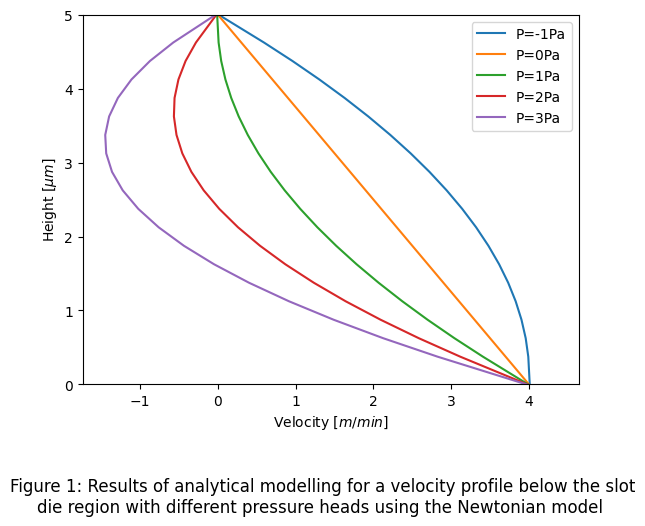

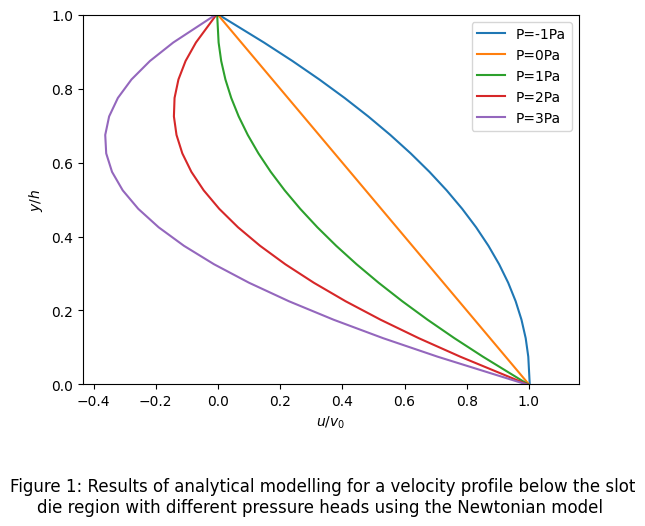

<Figure size 640x480 with 0 Axes>

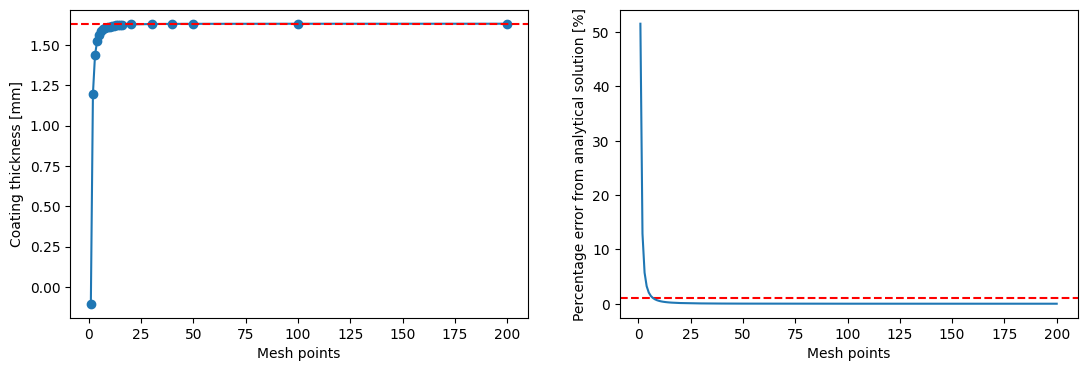

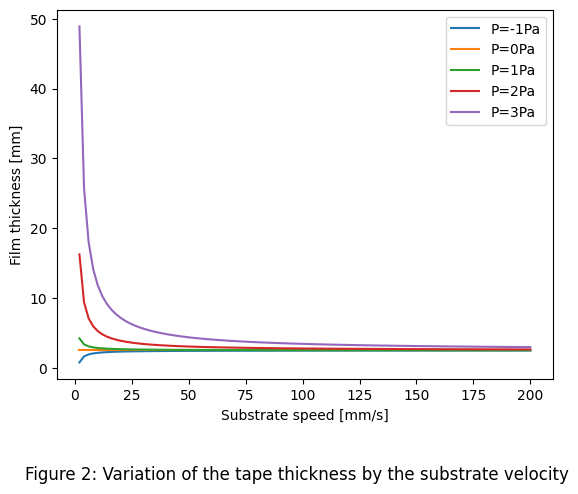

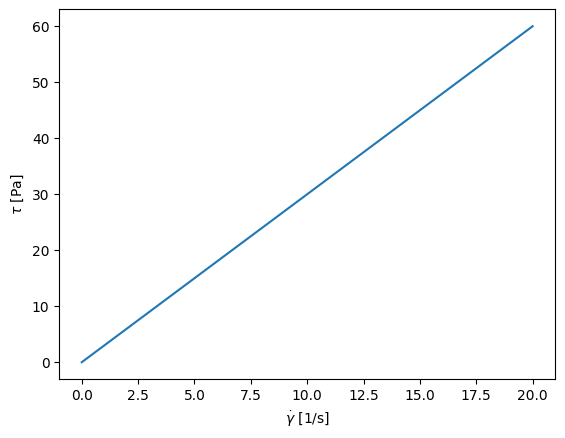

<Figure size 640x480 with 0 Axes>

In [8]:
#Add parameters
param = pybamm.ParameterValues(
    {
        "Pressure [Pa]": 1,
        "Yield stress [Pa]": 1.5,
        "Exponent parameter [t]": 3,
        "Coating Gap [mm]": 5,
        "Coating speed [mms-1]": 4,
        "Newtionian viscosity [Pa]": 3,
        "Shear strain [s-1]": 1,

        "Power-law index": 1,

    }
)


model = Newtonian(param=param)
model.velocity_profile(normalised=0)
model.velocity_profile(normalised=1)
model.thickness_convergence()
model.analytical_thickness(plot =1)
print(model.analytical_thickness(plot =0))
model.viscosity_profile()